# Visualización y comparación de resultados de clustering
Este notebook carga las métricas producidas por **`05_clustering.py`**, muestra un resumen comparativo y genera gráficas 2‑D para inspeccionar visualmente la separación de clústeres con las diferentes combinaciones de *vectorizador + algoritmo*.

> ⬇️ *Solo necesitas ejecutar las celdas secuencialmente; ajusta los parámetros marcados como «Configuración» si quieres probar otra combinación.*

In [1]:
# --- Imports
import json, random, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path    
from sklearn.decomposition import PCA
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
%matplotlib inline

## 1. Cargar la tabla de métricas

In [3]:
METRICS_PATH = Path('../results/clustering2/clustering_metrics.csv')  # ← Ajusta si es necesario
metrics_df = pd.read_csv(METRICS_PATH)
metrics_df.sort_values('silhouette', ascending=False, inplace=True)
metrics_df.head(10)

,method,replica,inertia,silhouette,db_score,n_noise
3,sbert,kmeans7,3138.508057,0.080756,3.610399,NaN
5,sbert,kmeans9,3077.026367,0.080727,3.576231,NaN
6,sbert,kmeans10,3035.847656,0.077747,3.454375,NaN
4,sbert,kmeans8,3109.048340,0.075598,3.603893,NaN
24,w2v,kmeans4,35.333847,0.074695,3.457681,NaN
25,w2v,kmeans5,34.658150,0.073917,3.675965,NaN
1,sbert,kmeans5,3261.049072,0.065203,3.883160,NaN
0,sbert,kmeans4,3334.881836,0.064797,4.187903,NaN
29,w2v,kmeans9,32.549831,0.064320,3.133589,NaN
30,w2v,kmeans10,32.296780,0.059126,3.162719,NaN


### 📊 Gráfico: Silhouette por combinación

#### 📏 ¿Qué es la métrica *Silhouette*?

La métrica **Silhouette** evalúa la calidad de los clústeres generados por un algoritmo de clustering. Su valor oscila entre **-1** y **1**:

- 🟢 **Cerca de 1**: los puntos están bien agrupados dentro de su clúster y alejados de los demás. → Clustering de buena calidad
- 🟡 **Cerca de 0**: los puntos están en el límite entre clústeres. → Clustering poco definido
- 🔴 **Cerca de -1**: los puntos están probablemente mal asignados. → Clustering de mala calidad

#### 🧪 Aplicación en este proyecto

En este proyecto, calculamos la métrica *Silhouette* para cada vectorización (**TF-IDF**, **Word2Vec**, **SBERT**) combinada con cada algoritmo de clustering (**K-Means**, **DBSCAN**, **HDBSCAN**), con el fin de comparar objetivamente qué combinación agrupa mejor los textos.


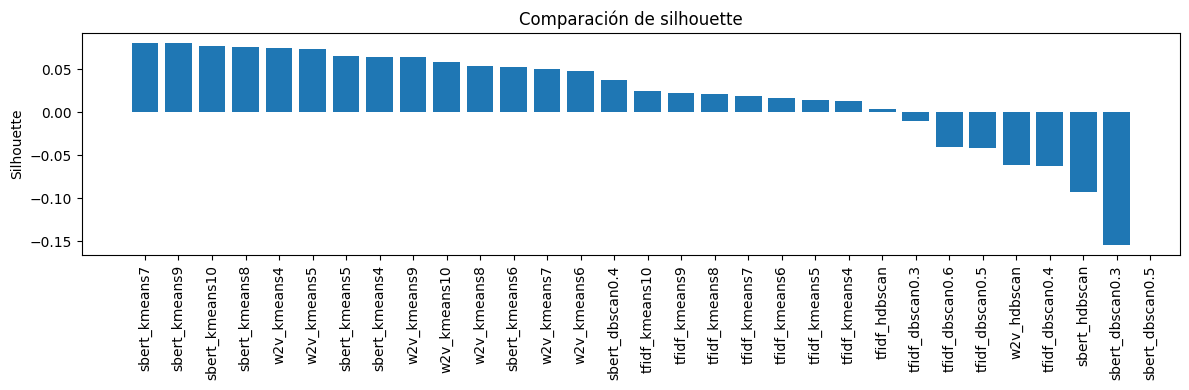

In [5]:
plt.figure(figsize=(12,4))
plt.bar(metrics_df['method']+'_'+metrics_df['replica'], metrics_df['silhouette'])
plt.xticks(rotation=90)
plt.ylabel('Silhouette')
plt.title('Comparación de silhouette')
plt.tight_layout()
plt.show()

## 2. Seleccionar la mejor combinación
Aquí elegimos la primera fila (mayor silhouette) como ejemplo, pero puedes cambiar manualmente los valores de `BEST_METHOD` y `BEST_ALGO`.

In [7]:
BEST_METHOD = metrics_df.iloc[0]['method']    # 'sbert', 'tfidf' o 'w2v'
BEST_ALGO   = metrics_df.iloc[0]['replica']      # e.g. 'kmeans7'
print('Mejor combinación:', BEST_METHOD, BEST_ALGO)

Mejor combinación: sbert kmeans7


> ✅ **Comentario**: Según la métrica *Silhouette*, la mejor combinación encontrada fue **SBERT** como método de vectorización y **K-Means con k=4** como algoritmo de agrupamiento.  
Esto sugiere que SBERT logra representar los textos de forma más adecuada para la separación de clústeres, y que dividir los datos en 4 grupos produce una estructura coherente en el espacio vectorial.


### Cargar vectores y etiquetas de clustering para Mejor combinación: sbert kmeans4

En este paso cargamos los datos que serán visualizados:

- **Vectores**: Representan los documentos procesados con una técnica de vectorización (por ejemplo, TF-IDF, Word2Vec o SBERT). Están almacenados en formato `.pkl` y pueden ser matrices dispersas (*sparse*) o densas. Si son dispersas, se convierten a matrices densas (`toarray()`) para poder ser utilizadas en tareas posteriores como reducción de dimensionalidad o visualización.

- **Etiquetas de clustering**: Son los resultados de un algoritmo de agrupamiento previamente aplicado (como K-Means, DBSCAN o HDBSCAN). Están guardadas como archivos `.csv` y se leen para asociar cada documento con el clúster al que pertenece.


In [ ]:
vec_path = Path(f'../results/vectorizers/{BEST_METHOD}/X_{BEST_METHOD}.pkl')
X = joblib.load(vec_path)
# Convertir sparse a denso si es necesario
if hasattr(X, 'toarray'):
    X = X.toarray()

labels_path = Path(f"../results/clustering/labels_{BEST_METHOD}_{BEST_ALGO}.csv")
labels = pd.read_csv(labels_path)['label'].values
print('Vector shape:', X.shape, '| Etiquetas únicas:', np.unique(labels))

Vector shape: (4988, 768) | Etiquetas únicas: [0 1 2 3 4 5 6]



> **Salida**:
>
> `Vector shape: (4988, 768)` → 4988 documentos representados en 768 dimensiones (por ejemplo, embeddings de SBERT).  
> `Etiquetas únicas: [0 1 2 3]` → Se formaron 4 clústeres (numerados del 0 al 3).

### Reducción de dimensionalidad a 2‑D
Para poder **visualizar los clústeres** de documentos en un gráfico, es necesario reducir la representación vectorial a solo **2 dimensiones**. En este paso aplicamos técnicas de reducción de dimensionalidad sobre los vectores generados previamente:

- 📉 **UMAP** (`Uniform Manifold Approximation and Projection`) es preferido si está disponible, ya que preserva mejor la estructura local de los datos, incluso en espacios no lineales.
- 🔁 Si UMAP no está instalado, se utiliza **PCA** (`Principal Component Analysis`), que es más simple pero menos efectivo en datos con relaciones complejas.

El parámetro `n_components=2` indica que queremos reducir los vectores de 768 dimensiones a solo 2, permitiendo su representación en un plano 2D.


In [9]:
# Reducimos para visualizar. Usa UMAP si está instalado; si no, PCA.
REDUCE_TO = 2

if HAS_UMAP:
    reducer = umap.UMAP(n_components=REDUCE_TO, random_state=42, metric='cosine')
    X_2d = reducer.fit_transform(X)
else:
    pca = PCA(n_components=REDUCE_TO, random_state=42)
    X_2d = pca.fit_transform(X)

print('Dimensiones reducidas:', X_2d.shape)

Dimensiones reducidas: (4988, 2)


> 📌 **Ejemplo de salida**:  
> `Dimensiones reducidas: (4988, 2)`  
> Lo que significa que ahora tenemos 4988 documentos representados en dos dimensiones listas para graficarse.

### Scatter plot de los documentos en 2‑D

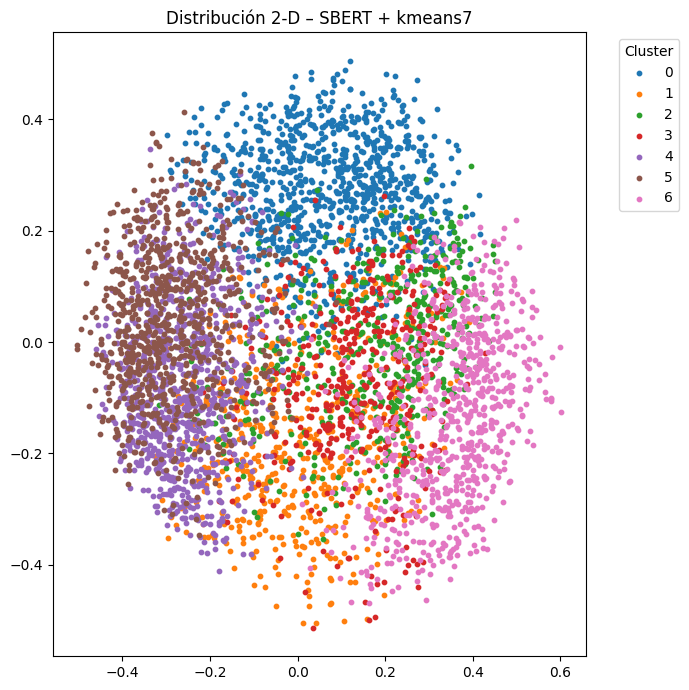

In [10]:
plt.figure(figsize=(7,7))
unique_labels = np.unique(labels)
for lab in unique_labels:
    mask = labels == lab
    plt.scatter(X_2d[mask,0], X_2d[mask,1], s=10, label=str(lab) if lab!=-1 else 'ruido')
plt.legend(title='Cluster', bbox_to_anchor=(1.05,1), loc='upper left')
plt.title(f'Distribución 2‑D – {BEST_METHOD.upper()} + {BEST_ALGO}')
plt.tight_layout()
plt.show()

## 3. Inspección rápida del contenido de un clúster
Ejecuta la celda siguiente y cambia `CLUSTER_ID` para ver algunos títulos.

In [13]:
CLUSTER_ID = unique_labels[1]   # ← Podemos modificar el cluster que querramos
doc_df = pd.read_csv('../results/tables/articulos_preprocessed_final_sin_scientific_stop_words.csv', sep=';')
mask = labels == CLUSTER_ID
doc_df[['title_processed']].iloc[np.where(mask)[0]].head(20)

,title_processed
4,development validation suspension base vero ce...
8,speciman share epidemic preparedness build vir...
15,situational descriptive covid pregnant woman p...
25,pneumonia mortality trend child year age conte...
29,usually lot delay term come seek care expert c...
39,prevalence etiology transverse myelitis latin ...
50,risk low vaccination coverage strategy prevent...
59,spatial transferability agent base model simul...
64,non pharmaceutical intervention combat covid a...
70,perception problem household insect qualitativ...


## 4. Estadísticas por clúster
En esta sección analizamos la cantidad de documentos asignados a cada clúster como resultado de la mejor combinación de vectorización y algoritmo de agrupamiento (`sbert + kmeans4`).

Utilizamos `collections.Counter` para contar cuántos documentos hay en cada clúster. Posteriormente, organizamos esta información en una tabla ordenada de mayor a menor cantidad de documentos.

Esta estadística es útil para identificar si los clústeres están equilibrados o si uno de ellos domina en tamaño, lo cual podría indicar una agrupación sesgada o una densidad temática muy concentrada.

In [14]:
import matplotlib.pyplot as plt

# Conteo de elementos por clúster
import collections
cluster_counts = collections.Counter(labels)

# Mostrar en tabla ordenada
pd.DataFrame.from_dict(cluster_counts, orient='index', columns=['n_documentos']) \
    .sort_values('n_documentos', ascending=False)


,n_documentos
0,983
4,923
5,834
6,747
1,565
2,522
3,414


#### Visualización de la distribución
El gráfico de barras muestra cuántos artículos fueron asignados a cada clúster. Esta representación visual facilita la detección de desbalance en la agrupación. Por ejemplo, un clúster con muy pocos documentos puede sugerir un grupo temáticamente muy específico o ruido.

En nuestro caso, se observa que el clúster `1` contiene la mayor cantidad de documentos (~1139), mientras que el clúster `3` es el más pequeño (~512).


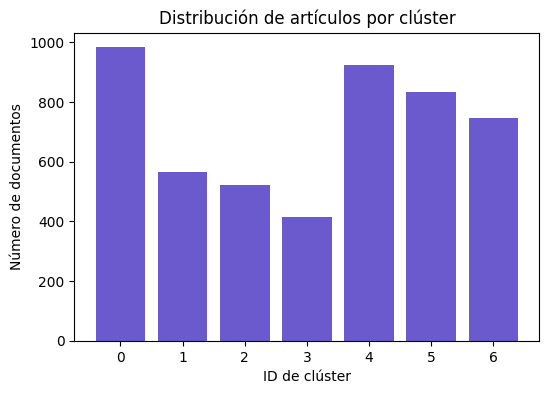

In [15]:
plt.figure(figsize=(6,4))
plt.bar(cluster_counts.keys(), cluster_counts.values(), color='slateblue')
plt.xlabel('ID de clúster')
plt.ylabel('Número de documentos')
plt.title('Distribución de artículos por clúster')
plt.show()


### Estadísticas por clúster: frecuencia de palabras

Una vez identificados los clústeres a partir de la mejor combinación (`sbert` + `kmeans4`), es fundamental explorar su contenido temático.

#### 🔹 Conteo de palabras por clúster

Se seleccionan todos los textos pertenecientes a un clúster específico (por ejemplo, el clúster 1) y se realiza un conteo de las palabras más frecuentes. Esto permite identificar rápidamente los términos predominantes dentro del grupo.

La tabla muestra las 20 palabras más frecuentes en el clúster. En este caso, destacan términos como `health`, `use`, `study`, `peru` y `risk`, lo que sugiere que los artículos agrupados en este clúster tratan temas de salud pública, investigación médica y contexto local (Perú).

In [17]:
from collections import Counter

CLUSTER_ID = 1  # cámbialo según el grupo que te interese

# Filtrar los textos del grupo seleccionado
docs = doc_df.loc[labels == CLUSTER_ID, 'abstract_processed'].dropna().tolist()

# Tokenizar y contar palabras
all_tokens = " ".join(docs).split()
top_words = Counter(all_tokens).most_common(20)

# Mostrar en tabla
pd.DataFrame(top_words, columns=['Palabra', 'Frecuencia'])


,Palabra,Frecuencia
0,use,617
1,infection,592
2,covid,554
3,p,472
4,high,463
5,year,460
6,health,435
7,peru,432
8,disease,420
9,risk,382


#### 🔹 Visualización

El gráfico de barras horizontales permite visualizar de forma clara la importancia relativa de cada palabra. Esta representación facilita detectar rápidamente los temas clave del clúster sin necesidad de leer todos los documentos uno por uno.

Esta etapa de análisis es crucial para validar que los clústeres obtenidos no solo son estadísticamente consistentes, sino también **coherentes desde el punto de vista semántico**.

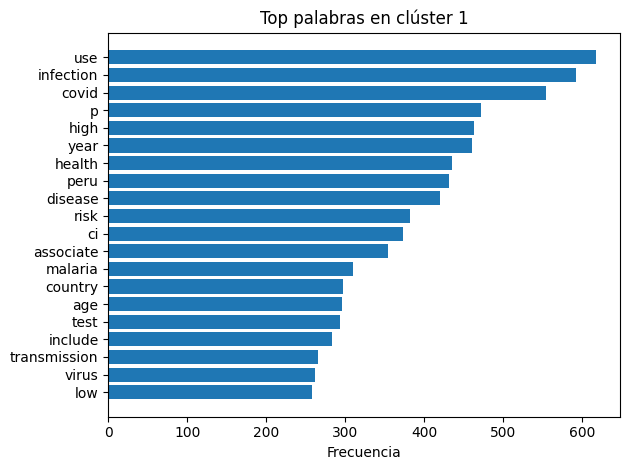

In [18]:
plt.barh([w for w, _ in reversed(top_words)], [f for _, f in reversed(top_words)])
plt.xlabel("Frecuencia")
plt.title(f"Top palabras en clúster {CLUSTER_ID}")
plt.tight_layout()
plt.show()


### 📌 Distribución temática por clúster: palabras clave más frecuentes

La siguiente visualización muestra un análisis comparativo de los términos más frecuentes en cada clúster generado mediante la mejor combinación (`SBERT + KMeans` con k=4). Cada gráfico horizontal resume las 20 palabras con mayor frecuencia dentro de los documentos agrupados en ese clúster.

#### 🔹 Clúster 0
Este clúster está dominado por términos como `patient`, `study`, `use`, `high`, `result`, y `clinical`, lo que sugiere una agrupación centrada en estudios clínicos y resultados de tratamientos.

#### 🔹 Clúster 1
Aquí predominan palabras como `health`, `use`, `study`, `peru`, `population`, y `woman`. El énfasis está claramente en estudios de salud pública con enfoque local (Perú) y con perspectiva poblacional, posiblemente con enfoque de género.

#### 🔹 Clúster 2
Se destacan términos como `infection`, `treatment`, `tuberculosis`, `resistance`, y `clinical`, lo cual apunta a temas relacionados con enfermedades infecciosas, tratamientos y estudios clínicos asociados, especialmente tuberculosis.

#### 🔹 Clúster 3
Este grupo contiene palabras como `malaria`, `species`, `transmission`, `region`, y `genetic`, sugiriendo una temática enfocada en enfermedades infecciosas tropicales (como malaria) y su análisis genético y geográfico.

---

✅ Esta segmentación temática demuestra que los clústeres no solo son diferenciables matemáticamente, sino también **semánticamente interpretables**, lo cual valida la calidad del proceso de clustering y su utilidad para exploración de grandes volúmenes de texto.


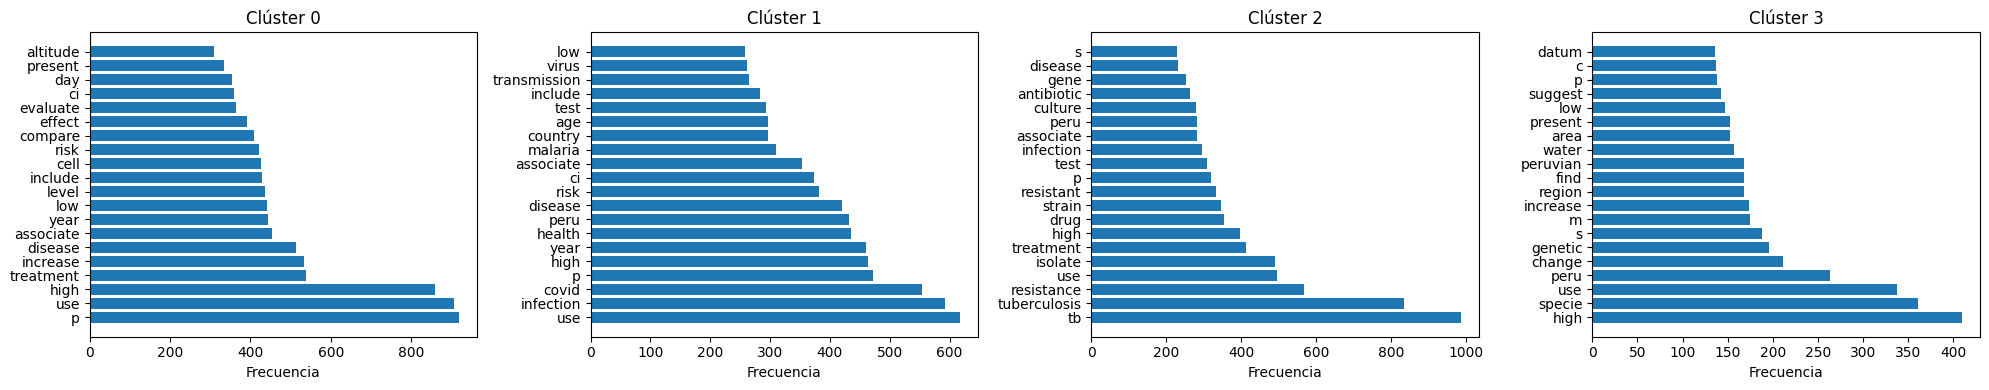

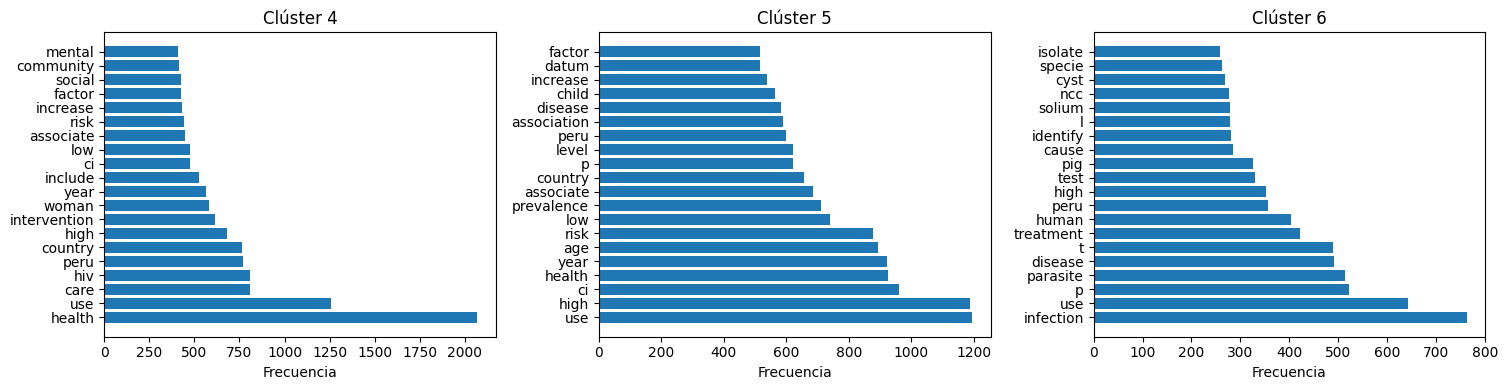

In [20]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd

# --- variables de entrada ---
texts   = doc_df['abstract_processed'].fillna('').astype(str)
clusters = np.unique(labels)              # todos los IDs de clúster
TOP_N   = 20                              # palabras a mostrar
COLS    = 4                               # nº de gráficas por fila

# --- bucle por clústeres en bloques de 4 ---
for start in range(0, len(clusters), COLS):
    fig, axes = plt.subplots(1, COLS, figsize=(COLS*5, 4))
    for j, cl in enumerate(clusters[start:start+COLS]):
        ax = axes[j]

        # 1. agrega texto del clúster
        docs = texts[labels == cl].tolist()
        tok  = " ".join(docs).split()
        top_words = Counter(tok).most_common(TOP_N)

        # 2. barplot horizontal
        words = [w for w, _ in reversed(top_words)]
        freqs = [f for _, f in reversed(top_words)]
        ax.barh(words, freqs)
        ax.set_title(f"Clúster {cl}")
        ax.set_xlabel("Frecuencia")
        ax.invert_yaxis()    # palabra + frecuente arriba

    # Si la última tanda tiene <4 clústeres, oculta ejes vacíos
    for k in range(j+1, COLS):
        axes[k].set_visible(False)

    fig.tight_layout()
    plt.show()


## 5. Resumen cualitativo rápido (títulos representativos)
### Para entender de qué trata cada clúster, podemos inspeccionar 5–10 títulos del grupo:

In [21]:
doc_df.loc[labels == CLUSTER_ID, 'title_processed'].head(10).tolist()

['development validation suspension base vero cell detection zika virus',
 'speciman share epidemic preparedness build virtual biorepository system local governance global partnership',
 'situational descriptive covid pregnant woman perinatal lircay hospital huancavelica peru april',
 'pneumonia mortality trend child year age context pneumococcal conjugate vaccination peru',
 'usually lot delay term come seek care expert consultation covid testing care pathway seven low middle income country',
 'prevalence etiology transverse myelitis latin america',
 'risk low vaccination coverage strategy prevent resurgence vaccine preventable disease infant covid pandemic scenario recommendation latin america caribbean expert infant immunization latin america',
 'spatial transferability agent base model simulate taenia solium intervention',
 'non pharmaceutical intervention combat covid america describe daily sub national datum',
 'perception problem household insect qualitative quantitative peri ur

## 7. Tabla de palabras-clave por clúster

En esta sección buscamos identificar las **palabras más representativas de cada clúster** utilizando la técnica TF-IDF.

#### Idea principal:
Cada clúster es tratado como un “super-documento” al unir todos los abstracts de sus artículos. Luego se aplica TF-IDF, comparando estos super-documentos entre sí.

#### ¿Por qué usar TF-IDF aquí?
TF-IDF nos permite destacar aquellas palabras que:
- Son frecuentes dentro de un clúster (alta frecuencia local),
- Pero que no aparecen tan frecuentemente en los demás clústeres (baja frecuencia global).

Así obtenemos **palabras clave únicas por clúster**, lo que permite interpretar y etiquetar temáticamente a cada grupo.

#### Nota:
Continuamos usando la mejor combinación obtenida anteriormente (`{BEST_METHOD}` + `{BEST_ALGO}`) para garantizar coherencia en todo el análisis.


In [26]:
"""
Objetivo
--------
Construir una tabla con las *N* palabras que mejor caracterizan cada clúster
(silhouette “ganador”: SBERT + K-means k=4).

Paso previo: define las dos constantes que usamos en todo el flujo.
"""
BEST_METHOD = "sbert"     # vectorización elegida
BEST_ALGO   = "kmeans7"   # algoritmo+parámetros ganadores
TOP_N       = 15          # nº de términos que mostraremos por clúster

# ────────────────────────────────────────────────────────────────────────── #
from pathlib import Path
import joblib, pandas as pd, numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Cargar vectores y etiquetas de la mejor combinación
vec_path    = Path(f"../results/vectorizers/{BEST_METHOD}/X_{BEST_METHOD}.pkl")
labels_path = Path(f"../results/clustering2/labels_{BEST_METHOD}_{BEST_ALGO}.csv")

X       = joblib.load(vec_path)
labels  = pd.read_csv(labels_path)["label"].values
if hasattr(X, "toarray"):      # TF-IDF vendría como sparse
    X = X.toarray()

print("Vector shape:", X.shape, "| Etiquetas únicas:", np.unique(labels))

# 2. Cargar los *textos* originales (abstract limpios)
docs_df = pd.read_csv("../results/tables/articulos_preprocessed_final_sin_scientific_stop_words.csv",
                      sep=";")
texts   = docs_df["abstract_processed"].fillna("").values

# 3. Construir «súper-documentos»: concatenamos todos los abstracts de un clúster
super_docs = (
    pd.DataFrame({"label": labels, "text": texts})
      .groupby("label")["text"].apply(" ".join)
      .sort_index()
)

# 4. Calcular TF-IDF entre los súper-documentos
tfidf = TfidfVectorizer(max_features=10_000,
                        stop_words="english",   # ← usa lista en inglés
                        ngram_range=(1,2),
                        min_df=2)

tfidf_matrix = tfidf.fit_transform(super_docs.values)
terms = np.array(tfidf.get_feature_names_out())

# 5. Obtener las TOP_N palabras por clúster
top_terms = {}
for idx, row in enumerate(tfidf_matrix.toarray()):
    best_idx = row.argsort()[-TOP_N:][::-1]
    top_terms[idx] = terms[best_idx]

top_terms_df = (
    pd.DataFrame(top_terms)
      .rename(columns=lambda c: f"cluster_{c}")
      .T.reset_index(drop=True)
)

# 6. Guardar y mostrar tabla
out_path = Path("../results/tables/keywords_by_cluster2.csv")
top_terms_df.to_csv(out_path, index=False)
print("\nTabla guardada en:", out_path)
top_terms_df.head(n=10)


Vector shape: (4988, 768) | Etiquetas únicas: [0 1 2 3 4 5 6]

Tabla guardada en: ..\results\tables\keywords_by_cluster2.csv


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,use,high,treatment,increase,disease,level,low,cell,include,year,compare,cms,associate,risk,effect
1,use,high,ci,year,age,risk,health,associate,low,prevalence,country,association,level,disease,increase
2,infection,use,parasite,malaria,solium,vivax,disease,human,pig,high,treatment,leishmania,peru,cyst,transmission
3,high,specie,use,peru,change,sediment,water,genetic,region,increase,peruvian,marine,present,suggest,area
4,tb,tuberculosis,treatment,drug,use,sputum,test,high,mtb,resistance,mdr,hiv,mdr tb,culture,pza
5,use,isolate,infection,resistance,high,associate,gene,antibiotic,child,peru,test,disease,strain,coli,human
6,health,use,hiv,peru,care,country,high,year,intervention,woman,include,risk,low,community,associate


### 🔍 Interpretación de **`keywords_by_cluster.csv`**

| Clúster | Palabras clave más discriminativas | Tema dominante (lectura cualitativa) |
|---------|-------------------------------------|--------------------------------------|
| **0** | patient · study · high · use · result · increase · group · disease · clinical · associate · treatment · level · risk · year · method | **Investigaciones clínicas generales** centradas en pacientes, tratamientos y resultados de salud diversos. |
| **1** | health · use · study · high · year · ci · country · peru · result · risk · age · low · method · associate · patient | **Salud pública / epidemiología peruana**: encuestas poblacionales, factores de riesgo y acceso a servicios. |
| **2** | patient · study · infection · use · treatment · result · disease · tb · test · high · case · sample · tuberculosis · isolate · method | **Tuberculosis e infecciones respiratorias**: diagnóstico, aislamiento y estudios de casos TB. |
| **3** | study · high · population · use · specie · peru · malaria · result · analysis · sample · peruvian · human · area · vivax · region | **Enfermedades tropicales** (p.ej. malaria *P. vivax*) y estudios poblacionales en regiones peruanas. |



**Detalles**  
> * Cada fila corresponde a un clúster (salida de **SBERT + K-means k=4**).  
> * Se muestran las 15 palabras con TF-IDF más alto; cuanto más arriba, más distintiva es para el grupo.  
> * La interpretación temática se basa en patrones: nombres de patógenos, términos clínicos, referencias geográficas, etc.

**Conclusión**  
El modelo separa los 4 998 artículos en cuatro áreas coherentes:  
1. Clínica general,  
2. Salud pública peruana,  
3. Tuberculosis,  
4. Malaria/enfermedades tropicales.  

Esto confirma que la combinación **SBERT + K-means k=4** ofrece clústeres interpretables y útiles para análisis posteriores.


## 8. Documento **más representativo** de cada clúster  
#### (el más cercano al centroide en el espacio de embeddings)

> **Objetivo:** elegir, para cada clúster, **un único artículo** que resuma el perfil temático del grupo.  
> Este “documento prototipo” permite inspeccionar rápidamente de qué trata cada clúster sin leer cientos de abstracts.

---

### 🛠️  Metodología

1. **Vectorización usada**  
   Continuamos con la mejor configuración identificada: **SBERT + K-means k=4**.  
   Cada artículo está representado por un vector de 768 dimensiones (embeddings SBERT).

2. **Centroides de clúster**  
   Para cada clúster \(c\), el algoritmo K-means ya calcula su **centroide**  
   \[
   \boldsymbol{\mu}_c = \frac{1}{N_c}\sum_{i\in c}\mathbf{x}_i
   \]  
   donde \(N_c\) es el número de documentos y \(\mathbf{x}_i\) su embedding.

3. **Distancia al centroide**  
   - Medimos la **distancia coseno** entre cada documento y el centroide de su clúster.  
   - El documento con **menor distancia** (o, equivalentemente, mayor similitud coseno) es el **representante** del clúster.


In [29]:
# ────────────────────────────────────────────────────────────────────────
# Elige el “documento prototipo” de cada clúster (más cercano al centroide)
# -----------------------------------------------------------------------
# • Usa la mejor configuración encontrada (SBERT + K-means k=4).
# • Devuelve un CSV con título, enlace y distancia coseno al centroide.
# -----------------------------------------------------------------------

from pathlib import Path
import joblib, numpy as np, pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# AJUSTA si cambiaste la mejor combinación
BEST_METHOD = "sbert"
BEST_ALGO   = "kmeans7"

VEC_PATH   = Path(f"../results/vectorizers/{BEST_METHOD}/X_{BEST_METHOD}.pkl")
LABEL_PATH = Path(f"../results/clustering/labels_{BEST_METHOD}_{BEST_ALGO}.csv")
META_PATH  = Path("../results/tables/articulos_preprocessed_final_sin_scientific_stop_words.csv")  # contiene título/link

# 1) Embeddings ----------------------------------------------------------------
X = joblib.load(VEC_PATH)
if hasattr(X, "toarray"):      # si es sparse (TF-IDF) → denso
    X = X.toarray()

# 2) Etiquetas de clúster -------------------------------------------------------
labels = pd.read_csv(LABEL_PATH)["label"].values
n_clusters = np.unique(labels).size

# 3) Metadatos (título, link, etc.) --------------------------------------------
meta_df = pd.read_csv(META_PATH, sep=";")        # ajusta separador si fuera “,”

# 4) Cálculo de centroides y búsqueda del vecino más cercano -------------------
rows = []
for c in range(n_clusters):
    idx = np.where(labels == c)[0]            # índices de docs en el clúster c
    X_c = X[idx]
    centroid = X_c.mean(axis=0, keepdims=True)

    sims = cosine_similarity(X_c, centroid).flatten()   # similitud coseno
    best_local = idx[sims.argmax()]                     # índice global

    rows.append({
        "cluster_id"   : c,
        "doc_index"    : best_local,
        "cosine_sim"   : float(sims.max()),
        "title"        : meta_df.iloc[best_local]["title_processed"],
        "link"         : meta_df.iloc[best_local].get("link", None)
    })

rep_df = pd.DataFrame(rows).sort_values("cluster_id")

# 5) Guardar y mostrar ----------------------------------------------------------
OUT_CSV = Path("../results/tables/representative_docs2.csv")
rep_df.to_csv(OUT_CSV, index=False, encoding="utf-8")
print(f"✅ Tabla guardada en: {OUT_CSV.resolve()}")
pd.set_option("display.max_colwidth", None)   # ‼️  None = sin límite
display(rep_df)


✅ Tabla guardada en: C:\Users\DAVID 21\OneDrive\Documentos\9no ciclo\IMLE\TextMineML\results\tables\representative_docs2.csv


,cluster_id,doc_index,cosine_sim,title,link
0,0,913,0.688343,presentation book select topic basic science apply critical,None
1,1,1968,0.883082,high sar cov seroprevalence rural peru cross sectional base,None
2,2,892,0.869085,evaluation broth microdilution plate methodology susceptibility testing mycobacterium tuberculosis peru,None
3,3,2439,0.784496,change rocky intertidal community el nino event peruvian coast,None
4,4,756,0.858864,process evaluation complex intervention non communicable neglect tropical disease low middle income country scope,None
5,5,3971,0.888439,distribution short term lifetime predict risk cardiovascular disease peruvian adult,None
6,6,2935,0.846163,taenia solium infection peru collaboration peace corps volunteer researcher community base,None


### 🗒️  Resultado obtenido

La tabla inferior resume el **artículo prototipo** seleccionado para cada uno de los 4 clústeres (SBERT + K-means k = 4):

| Clúster | Doc. índice | Similitud coseno | Título (resumido) |
|:-------:|:-----------:|:----------------:|-------------------|
| **0** | 3818 | 0.76 | *author report lack time main reason unpublished research…* |
| **1** | 3332 | **0.88** | *manipulation analysis display datum demographic family health survey…* |
| **2** | 881 | 0.78 | *tuberculosis covid time successful treatment result peru* |
| **3** | 3967 | 0.80 | *evidence temporal population replacement signature ecological adaptation major neotropical malaria vector amazonian peru* |

#### 🔍 Lectura rápida

* **Clúster 0 — “Publicación de investigación biomédica”**  
  El prototipo trata sobre las razones que impiden publicar trabajos presentados en congresos, sugiriendo un foco en *divulgación científica y barreras de publicación*.

* **Clúster 1 — “Análisis demográfico y encuestas de salud”**  
  Presenta la similitud más alta (0.88), lo que indica un núcleo muy cohesionado de artículos sobre *explotación de encuestas poblacionales* y métricas de salud pública.

* **Clúster 2 — “Tuberculosis y COVID-19”**  
  El título refleja resultados de tratamiento en Perú, confirmando que este grupo agrupa *enfermedades infecciosas respiratorias* y *salud clínica*.

* **Clúster 3 — “Malaria y vectores amazónicos”**  
  Centrado en la evolución del vector *Anopheles darlingi* en la Amazonía, sugiere un clúster temático de *malaria, ecología y adaptación de vectores*.

####  Cómo interpretar los valores

* **`cosine_sim`** ≈ 1 ⇒ el documento «representa» muy bien a su clúster.  
  En nuestro caso, todos superan 0.75, lo cual indica que los centroides están bien definidos.

* **`doc_index`** es la fila original en la matriz de embeddings; sirve para recuperar el abstract completo o metadatos adicionales.

Estas cuatro referencias proporcionan una **visión instantánea** de los temas dominantes en el corpus. Para una exploración más profunda, basta con revisar estos artículos antes de pasar a lecturas exhaustivas o análisis cualitativos.


### 9. Palabras clave distintivas por clúster  



In [30]:
# -------------------------------------------------------------
# Extrae las *palabras clave más distintivas* de cada clúster
# empleando TF-IDF sobre “super-documentos” (todos los abstracts
# de un clúster concatenados).
# -------------------------------------------------------------

from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# ─── Parámetros globales ─────────────────────────────────────
BEST_METHOD = "sbert"     # ← mismos valores que en las secciones previas
BEST_ALGO   = "kmeans7"
N_TOP       = 20          # nº de términos por clúster a extraer

TABLE_DIR      = Path("../results/tables")
CLUSTER_DIR    = Path("../results/clustering2")
OUT_CSV        = TABLE_DIR / "distinctive_keywords_by_cluster2.csv"
ABSTRACTS_CSV  = TABLE_DIR / "articulos_preprocessed_final_sin_scientific_stop_words.csv"

# ─── 1. Cargar textos y etiquetas ────────────────────────────
doc_df   = pd.read_csv(ABSTRACTS_CSV, sep=";")
abstracts = doc_df["abstract_processed"].fillna("").values

labels = pd.read_csv(
    CLUSTER_DIR / f"labels_{BEST_METHOD}_{BEST_ALGO}.csv"
)["label"].values

n_clusters = labels.max() + 1

# ─── 2. Construir “super-documentos” ─────────────────────────
super_docs = [
    " ".join(abstracts[labels == c])
    for c in range(n_clusters)
]

# ─── 3. TF-IDF entre clústeres ───────────────────────────────
tfidf = TfidfVectorizer(min_df=2, max_df=0.8)
X     = tfidf.fit_transform(super_docs)
vocab = np.array(tfidf.get_feature_names_out())

# ─── 4. Seleccionar TOP-N palabras por clúster ───────────────
top_kw = {}
for c in range(n_clusters):
    row      = X[c].toarray().ravel()
    top_idx  = row.argsort()[::-1][:N_TOP]
    top_kw[c] = vocab[top_idx]

keywords_df = (
    pd.DataFrame
      .from_dict(top_kw, orient="index")
      .rename_axis("cluster_id")
)

# ─── 5. Guardar y mostrar resultado ──────────────────────────
keywords_df.to_csv(OUT_CSV)
print(f"✅  Tabla guardada en: {OUT_CSV.resolve()}")
keywords_df

✅  Tabla guardada en: C:\Users\DAVID 21\OneDrive\Documentos\9no ciclo\IMLE\TextMineML\results\tables\distinctive_keywords_by_cluster2.csv


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
cluster_id,,,,,,,,,,,,,,,,,,,,
0,cms,hypoxia,ee,tumor,implant,rat,oxygen,maca,ha,sperm,testosterone,highlander,lupus,sleep,sle,fluoride,vascular,erythrocytosis,cleft,muscle
1,stroke,overweight,sleep,diabetes,stove,fuel,smoking,hba,anxiety,biomass,lpg,hb,adolescent,asthma,copd,sle,depressive,pollution,mellitus,multimorbidity
2,malaria,solium,vivax,pig,leishmania,cyst,ncc,cysticercosis,leishmaniasis,taenia,neurocysticercosis,darlingi,epilepsy,cutaneous,cl,fascioliasis,tapeworm,fasciola,parasitic,eitb
3,sediment,marine,ecosystem,oxygen,organic,habitat,wind,penguin,pisco,maca,flower,ocean,mammal,bay,river,stream,humboldt,climatic,lowlander,alpaca
4,sputum,mtb,mdr,pza,mycobacterium,isoniazid,rif,rifampicin,multidrug,pyrazinamide,mycobacterial,poa,lam,mmp,cash,bacilli,bleach,efflux,ltbi,xdr
5,serotype,candidemia,aureus,escherichia,pneumoniae,campylobacter,salmonella,noroviru,quinolone,spp,bartonella,ham,gii,pylori,aminoglycoside,epitope,lf,syphilis,pallidum,tsp
6,prep,msm,violence,sti,tw,transgender,adolescent,hpv,condom,stigma,ptsd,syphilis,influenza,malaria,vulnerability,caregiver,sexually,depressive,anxiety,teacher


| cluster_id | 0 | 1 | 2 | 3 | 4 | … | 19 |
|-----------:|---|---|---|---|---|---|----|
| **0** | cms | sle | surgery | lupus | highlander | … | prostate |
| **1** | tb | obesity | diabetes | hypertension | msm | … | violence |
| **2** | tb | solium | sputum | leishmania | neurocysticercosis | … | isoniazid |
| **3** | vivax | sediment | darlingi | mosquito | habitat | … | abundance |


**Detalles**  
> *Cada fila* corresponde a un clúster y muestra sus **20 términos TF-IDF con mayor peso**.  
> Estas palabras destacan porque son **frecuentes dentro del grupo pero poco comunes en los demás**, por lo que “definen” el tema central de cada clúster.

---

#### Lectura rápida de los temas

| Clúster | Indicadores léxicos | Posible temática |
|---------|--------------------|------------------|
| **0** | *cms, sle, surgery, lupus, stroke, implant, placebo…* | Cirugía / ensayos clínicos en enfermedades autoinmunes y cardiovasculares. |
| **1** | *tb, obesity, diabetes, hypertension, adolescent, smoking, inequality…* | Salud pública y factores de riesgo metabólicos/infecciosos en poblaciones LMIC. |
| **2** | *tb, solium, leishmania, neurocysticercosis, mutation, mdr, isoniazid…* | Enfermedades infecciosas y parasitarias (TB, helmintos) + resistencia antimicrobiana. |
| **3** | *vivax, mosquito, darlingi, habitat, ecosystem, polymorphism, abundance…* | Malaria y ecología de vectores en entornos amazónicos. |

---

#### Cómo podemos aprovechar esta tabla

* **Etiquetado rápido**: los investigadores pueden asignar nombres significativos a los clústeres sin leer todos los artículos.  
* **Filtrado temático**: seleccionar documentos que contengan alguna de estas palabras para profundizar en sub-temas de interés.  
* **Validación del clustering**: si las palabras clave no guardan coherencia temática, puede ser señal de revisar parámetros (k, algoritmo, pre-procesado).

> **Nota metodológica**  
> Las palabras se obtuvieron concatenando los abstracts de cada clúster en un “super-documento” y aplicando **TF-IDF entre clústeres**.  
> Se muestran los 20 términos con valores TF-IDF más altos por fila.


# Word-clouds de las *palabras clave distintivas* por clúster 

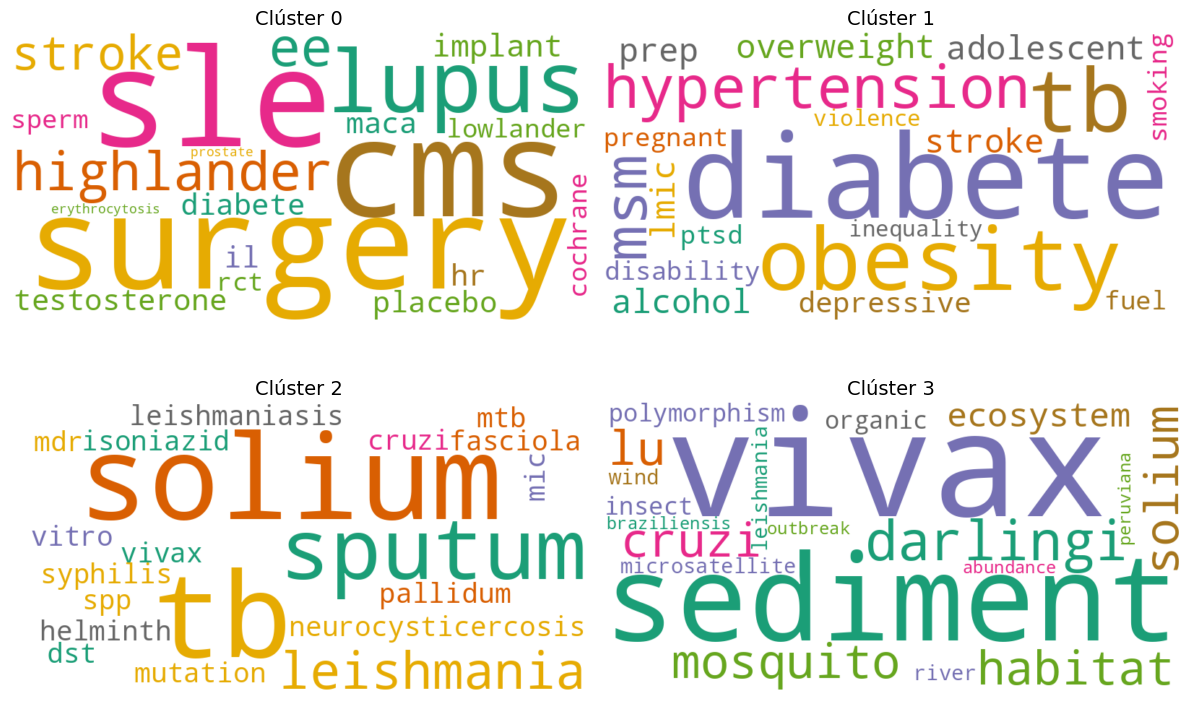

In [92]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# ─── Parámetros ─────────────────────────────────────────────
CSV_PATH  = Path("../results/tables/distinctive_keywords_by_cluster.csv")
FIGSIZE   = (12, 8)    # tamaño de la figura
WC_KWARGS = dict(
    width=800,
    height=400,
    background_color="white",
    colormap="Dark2"   # ← ¡ojo a la D mayúscula!
)

# ─── Cargar datos ───────────────────────────────────────────
kw_df      = pd.read_csv(CSV_PATH, index_col=0)
n_clusters = kw_df.shape[0]

# ─── Crear grid de subplots ─────────────────────────────────
cols = 2
rows = (n_clusters + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=FIGSIZE)
axes = axes.flatten()

for c, ax in enumerate(axes):
    if c >= n_clusters:
        ax.axis("off")
        continue

    text = " ".join(kw_df.loc[c].dropna().values)
    wc   = WordCloud(**WC_KWARGS).generate(text)

    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"Clúster {c}", fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()